# CycleGAN

Dalam notebook ini, kita akan mengimplementasikan [CycleGAN](https://arxiv.org/abs/1703.10593) oleh Zhu et al., 2017. Sebelumnya, pelatihan GAN memerlukan dataset gambar yang berpasangan. CycleGAN mengusulkan cara untuk menggunakan gambar yang tidak berpasangan.

Anda akan melatih model yang dapat mengonversi kuda menjadi zebra, dan sebaliknya.

![CycleGAN](https://huggingface.co/datasets/hf-vision/course-assets/resolve/main/cycleGAN1.jpg)

Inovasi utama CycleGAN terletak pada penggunaan dua generator dan dua discriminator, yang membentuk dua fungsi pemetaan antara dua domain (misalnya, kuda ke zebra dan zebra ke kuda, atau 🙂 -> 🤗 dan 🤗 -> 🙂). Generator bertujuan untuk menerjemahkan gambar dari satu domain ke domain lainnya, sementara discriminator mencoba membedakan antara gambar hasil terjemahan ("palsu") dan gambar asli dari domain target.

Salah satu komponen paling penting dalam CycleGAN adalah *cycle consistency loss*. Loss ini memastikan bahwa sebuah gambar dapat diterjemahkan dari satu domain ke domain lain dan kemudian kembali lagi, sehingga hasil akhirnya mendekati gambar aslinya. *Cycle consistency loss* membantu mempelajari terjemahan yang bermakna tanpa memerlukan contoh yang berpasangan, dengan memanfaatkan gagasan bahwa jika kita menerjemahkan gambar dari domain A ke domain B dan kembali ke domain A, siklus ini seharusnya membawa kita kembali ke gambar awal.

## Getting Started

Kita akan mulai dengan mengimpor beberapa pustaka yang diperlukan.

In [5]:
import torch
from torch import nn
from tqdm import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import glob
import random
import os
from torch.utils.data import Dataset
from PIL import Image
import requests
import zipfile
import io
import torch.nn.functional as F
import torchvision
import datasets

Kode di bawah ini mengunduh dataset zebra2horses dari [repositori Hugging Face](https://huggingface.co/datasets/johko/horse2zebra).

In [6]:
dataset = datasets.load_dataset("johko/horse2zebra", split="train")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/427 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/17.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/400 [00:00<?, ? examples/s]

Dataset ini mengandung empat label yang berbeda:

| ClassLabel | IntLabel |
|---------|-------|
| testA   | 0     |
| testB   | 1     |
| trainA | 2     |
| trainB | 3     |

In [7]:
dataset.features["label"]

ClassLabel(names=['testA', 'testB', 'trainA', 'trainB'], id=None)

Selanjutnya, kita mendefinisikan fungsi kelas dataset kustom dan transformasi. Kelas ini mengambil sampel yang diberi label 'train' dari dataset dan membuat satu daftar untuk sampel A dan satu lagi untuk sampel B.
Ketika kita mendapatkan item dari kelas Dataset kustom, kita mengembalikan sampel A dan B dengan transformasi yang diterapkan (yang akan didefinisikan lebih lanjut di bawah).

In [8]:
# Terinspirasi dari https://github.com/aitorzip/PyTorch-CycleGAN/blob/master/datasets.py
class ImageDataset(Dataset):
    def __init__(self, dataset: datasets.Dataset, transform=None, mode='train'):
        self.transform = transform
        # Memfilter dataset untuk mendapatkan gambar dengan label 2 (A) dan label 3 (B)
        self.files_A = dataset.filter(lambda x: x['label'] == 2)["image"]
        self.files_B = dataset.filter(lambda x: x['label'] == 3)["image"]

        # Menyusun ulang jika jumlah gambar A lebih banyak dari B
        if len(self.files_A) > len(self.files_B):
            self.files_A, self.files_B = self.files_B, self.files_A

        # Membuat permutasi acak baru
        self.new_perm()

        # Memastikan bahwa gambar A ada
        assert len(self.files_A) > 0, "Pastikan Anda sudah mengunduh gambar horse2zebra!"

    def new_perm(self):
        # Membuat permutasi acak dari gambar B
        self.randperm = torch.randperm(len(self.files_B))[:len(self.files_A)]

    def __getitem__(self, index):
        # Mengambil gambar A dan B dengan transformasi yang telah ditentukan
        item_A = self.transform(self.files_A[index % len(self.files_A)])
        item_B = self.transform(self.files_B[self.randperm[index]])

        # Menambahkan saluran warna (channels) jika gambar A atau B tidak memiliki 3 saluran
        if item_A.shape[0] != 3:
            item_A = item_A.repeat(3, 1, 1)
        if item_B.shape[0] != 3:
            item_B = item_B.repeat(3, 1, 1)

        # Jika indeks mencapai akhir, buat permutasi baru
        if index == len(self) - 1:
            self.new_perm()

        # Normalisasi gambar dari range [0, 1] ke [-1, 1]
        return (item_A - 0.5) * 2, (item_B - 0.5) * 2

    def __len__(self):
        # Mengembalikan panjang dataset yang lebih kecil antara A dan B
        return min(len(self.files_A), len(self.files_B))

In [9]:
import torchvision

load_shape = 286
target_shape = 256

transform = transforms.Compose([
    transforms.Resize(load_shape),
    transforms.RandomCrop(target_shape),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

dataset = ImageDataset(dataset, transform=transform)

Filter:   0%|          | 0/400 [00:00<?, ? examples/s]

Filter:   0%|          | 0/400 [00:00<?, ? examples/s]

In [10]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Fungsi untuk memvisualisasikan gambar: Diberikan tensor gambar, jumlah gambar, dan
    ukuran per gambar, fungsi ini akan menggambar dan menampilkan gambar dalam grid yang seragam.
    '''
    # Menormalisasi gambar dari rentang [-1, 1] ke rentang [0, 1]
    image_tensor = (image_tensor + 1) / 2
    image_shifted = image_tensor

    # Meratakan tensor gambar dan memindahkannya ke CPU untuk diproses
    image_unflat = image_shifted.detach().cpu().view(-1, *size)

    # Membuat grid gambar dari tensor gambar yang sudah diratakan
    image_grid = make_grid(image_unflat[:num_images], nrow=5)

    # Menampilkan gambar grid
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

## Generator

Generator CycleGAN terdiri dari blok encoding, blok residual, dan kemudian blok decoding.

### Residual Block:
Blok-blok ini menambahkan output dari lapisan konvolusi ke input, memungkinkan perubahan minimal pada gambar. Metode ini bertindak sebagai koneksi lompatan (skip connection), yang memfasilitasi jaringan yang lebih dalam dengan mengurangi masalah gradien yang menghilang (vanishing gradients) dan memungkinkan pembelajaran fitur yang lebih kompleks.

In [11]:
class ResidualBlock(nn.Module):
    '''
    Mendefinisikan sebuah blok residual untuk jaringan neural.

    Blok ini terdiri dari dua lapisan konvolusional dengan normalisasi instansi,
    diikuti oleh fungsi aktivasi. Input ditambahkan ke output dari
    lapisan-lapisan ini, membentuk output akhir dari blok.
    '''

    def __init__(self, input_channels):
        '''
        Menginisialisasi ResidualBlock.

        Parameter:
        input_channels (int): Jumlah saluran dalam tensor input.
        '''
        super(ResidualBlock, self).__init__()

        # Lapisan konvolusional pertama dengan padding reflektif
        self.conv1 = nn.Conv2d(input_channels, input_channels, kernel_size=3, padding=1, padding_mode="reflect")

        # Lapisan konvolusional kedua dengan padding reflektif
        self.conv2 = nn.Conv2d(input_channels, input_channels, kernel_size=3, padding=1, padding_mode="reflect")

        # Lapisan normalisasi instansi
        self.instancenorm = nn.InstanceNorm2d(input_channels)

        # Fungsi aktivasi (ReLU)
        self.activation = nn.ReLU()

    def forward(self, x):
        '''
        Mendefinisikan proses maju dari ResidualBlock.

        Parameter:
        x (Tensor): Tensor input untuk blok residual.

        Mengembalikan:
        Tensor: Tensor output setelah menerapkan operasi pada blok residual.
        '''
        # Menyimpan input asli untuk digunakan dalam koneksi skip
        original_tensor_image = x.clone()

        # Operasi konvolusional pertama
        x = self.conv1(x)
        x = self.instancenorm(x)
        x = self.activation(x)

        # Operasi konvolusional kedua
        x = self.conv2(x)
        x = self.instancenorm(x)

        # Menambahkan tensor asli ke output (koneksi skip)
        return original_tensor_image + x


### Encoder and Decoder Blocks:
Blok encoder mengurangi dimensi input ("mengontraksi"), sementara blok decoder melakukan upsampling ("memperbesar") menjadi dimensi output.


In [12]:
class EncoderBlock(nn.Module):
    '''
    Kelas EncoderBlock:
    Kelas yang digunakan untuk membuat blok encoder dalam jaringan neural, yang terdiri dari lapisan konvolusional,
    lapisan normalisasi instansi opsional, dan fungsi aktivasi.
    Atribut:
        conv1: Lapisan Conv2d untuk mengurangi dimensi spasial dan meningkatkan saluran.
        instancenorm: Lapisan InstanceNorm2d untuk normalisasi (opsional).
        activation: Fungsi aktivasi (ReLU atau LeakyReLU).
        use_bn: Boolean, apakah menggunakan normalisasi batch.
    '''

    def __init__(self, input_channels, use_bn=True, kernel_size=3, activation='relu'):
        super(EncoderBlock, self).__init__()
        # Membuat lapisan konvolusional dengan stride 2 untuk downsampling
        self.conv1 = nn.Conv2d(input_channels, input_channels * 2, kernel_size=kernel_size, padding=1, stride=2, padding_mode='reflect')
        # Memilih fungsi aktivasi berdasarkan argumen input
        if activation == 'relu':
            self.activation = nn.ReLU()
        else:
            self.activation = nn.LeakyReLU(0.2)
        # Menambahkan normalisasi instansi jika use_bn adalah True
        if use_bn:
            self.instancenorm = nn.InstanceNorm2d(input_channels * 2)

        self.use_bn = use_bn

    def forward(self, x):
        '''
        Fungsi untuk proses maju dari EncoderBlock:
        Menerapkan konvolusi, normalisasi opsional, dan aktivasi pada tensor input.
        '''
        x = self.conv1(x)
        if self.use_bn:
            x = self.instancenorm(x)
        x = self.activation(x)
        return x

class DecoderBlock(nn.Module):
    '''
    Kelas DecoderBlock:
    Kelas yang digunakan untuk membuat blok decoder dalam jaringan neural, yang terdiri dari lapisan konvolusional transpos
    (untuk upsampling), lapisan normalisasi instansi opsional, dan fungsi aktivasi ReLU.
    Atribut:
        conv1: Lapisan ConvTranspose2d untuk upsampling dan mengurangi saluran.
        instancenorm: Lapisan InstanceNorm2d untuk normalisasi (opsional).
        use_bn: Boolean, apakah menggunakan normalisasi batch.
        activation: Fungsi aktivasi ReLU.
    '''

    def __init__(self, input_channels, use_bn=True):
        super(DecoderBlock, self).__init__()
        # Lapisan konvolusional transpos untuk upsampling
        self.conv1 = nn.ConvTranspose2d(input_channels, input_channels // 2, kernel_size=3, stride=2, padding=1, output_padding=1)
        # Menambahkan normalisasi instansi jika use_bn adalah True
        if use_bn:
            self.instancenorm = nn.InstanceNorm2d(input_channels // 2)
        self.use_bn = use_bn
        # Fungsi aktivasi ReLU
        self.activation = nn.ReLU()

    def forward(self, x):
        '''
        Fungsi untuk proses maju dari DecoderBlock:
        Menerapkan konvolusi transpos, normalisasi opsional, dan aktivasi pada tensor input.
        '''
        x = self.conv1(x)
        if self.use_bn:
            x = self.instancenorm(x)
        x = self.activation(x)
        return x

### Feature Map Block:
Blok konvolusional digunakan untuk mengonversi antara saluran tersembunyi ke saluran input dan output.

In [13]:
class FeatureMapBlock(nn.Module):
    '''
    Kelas FeatureMapBlock:
    Kelas untuk blok konvolusional dasar yang digunakan untuk memodifikasi jumlah peta fitur
    tanpa mengubah dimensi spasial dari input.
    Atribut:
        conv: Lapisan Conv2d dengan ukuran kernel yang lebih besar untuk menangkap fitur tanpa mengurangi ukuran spasial.
    '''

    def __init__(self, input_channels, output_channels):
        super(FeatureMapBlock, self).__init__()
        # Lapisan konvolusional dengan ukuran kernel yang lebih besar untuk pemetaan fitur
        self.conv = nn.Conv2d(input_channels, output_channels, kernel_size=7, padding=3, padding_mode='reflect')

    def forward(self, x):
        '''
        Fungsi untuk proses maju dari FeatureMapBlock:
        Menerapkan konvolusi pada tensor input untuk mengubah jumlah peta fitur.
        '''
        x = self.conv(x)
        return x

## CycleGAN Generator
Sekarang, mari kita gabungkan semua blok untuk membuat Generator CycleGAN Anda.

In [14]:
class Generator(nn.Module):

    def __init__(self, input_channels, output_channels, hidden_channels=64):
        super(Generator, self).__init__()

        self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
        self.encoder1 = EncoderBlock(hidden_channels)
        self.encoder2 = EncoderBlock(hidden_channels * 2)

        res_mult = 4
        self.res0 = ResidualBlock(hidden_channels * res_mult)
        self.res1 = ResidualBlock(hidden_channels * res_mult)
        self.res2 = ResidualBlock(hidden_channels * res_mult)
        self.res3 = ResidualBlock(hidden_channels * res_mult)
        self.res4 = ResidualBlock(hidden_channels * res_mult)
        self.res5 = ResidualBlock(hidden_channels * res_mult)
        self.res6 = ResidualBlock(hidden_channels * res_mult)
        self.res7 = ResidualBlock(hidden_channels * res_mult)
        self.res8 = ResidualBlock(hidden_channels * res_mult)

        self.decoder1 = DecoderBlock(hidden_channels * 4)
        self.decoder2 = DecoderBlock(hidden_channels * 2)

        self.downfeature = FeatureMapBlock(hidden_channels, output_channels)
        self.tanh = torch.nn.Tanh()

    def forward(self, x):
        x0 = self.upfeature(x)
        x1 = self.encoder1(x0)
        x2 = self.encoder2(x1)
        x3 = self.res0(x2)
        x4 = self.res1(x3)
        x5 = self.res2(x4)
        x6 = self.res3(x5)
        x7 = self.res4(x6)
        x8 = self.res5(x7)
        x9 = self.res6(x8)
        x10 = self.res7(x9)
        x11 = self.res8(x10)
        x12 = self.decoder1(x11)
        x13 = self.decoder2(x12)
        xn = self.downfeature(x13)
        return self.tanh(xn)

## Discriminator Block
Sekarang, kita akan mendefinisikan blok discriminator.

In [15]:
class Discriminator(nn.Module):
    '''
    Kelas Discriminator:
    Menentukan jaringan diskriminator untuk model generatif, seperti GAN.
    Peran diskriminator adalah untuk membedakan antara data asli dan palsu (yang dihasilkan).

    Atribut:
        input_channels (int): Jumlah saluran input (misalnya, untuk gambar RGB, ini akan menjadi 3).
        hidden_channels (int): Jumlah saluran dasar yang digunakan dalam jaringan, yang meningkat di lapisan yang lebih dalam.
    '''
    def __init__(self, input_channels, hidden_channels=64):
        super(Discriminator, self).__init__()

        # Pemetaan fitur awal untuk meningkatkan jumlah saluran
        self.upfeature = FeatureMapBlock(input_channels, hidden_channels)

        # Blok kontraksi (Blok Encoder) - mengurangi dimensi spasial dan meningkatkan kedalaman saluran
        # Menggunakan aktivasi LeakyReLU (lrelu) untuk setiap blok kontraksi
        self.contract1 = EncoderBlock(hidden_channels, use_bn=False, kernel_size=4, activation='lrelu')
        self.contract2 = EncoderBlock(hidden_channels * 2, kernel_size=4, activation='lrelu')
        self.contract3 = EncoderBlock(hidden_channels * 4, kernel_size=4, activation='lrelu')

        # Konvolusi terakhir untuk menghasilkan satu saluran (klasifikasi biner untuk asli atau palsu)
        self.final = nn.Conv2d(hidden_channels * 8, 1, kernel_size=1)

    def forward(self, x):
        '''
        Menentukan proses maju dari diskriminator.
        '''
        # Terapkan secara berurutan pemetaan fitur dan blok kontraksi
        x0 = self.upfeature(x)
        x1 = self.contract1(x0)
        x2 = self.contract2(x1)
        x3 = self.contract3(x2)

        # Terapkan konvolusi terakhir
        xn = self.final(x3)
        return xn

## Training Preperation

Sekarang Anda dapat menyatukan semuanya untuk pelatihan! Anda akan mulai dengan mendefinisikan parameter-parameter Anda:

  *   `adv_criterion`: fungsi loss adversarial untuk melacak seberapa baik GAN menipu discriminator dan seberapa baik discriminator menangkap GAN.
  *   `recon_criterion`: fungsi loss yang memberi penghargaan pada gambar yang mirip dengan ground truth, yang "membangun kembali" gambar.
  *   `n_epochs`: jumlah iterasi melalui seluruh dataset saat pelatihan.
  *   `dim_A`: jumlah saluran gambar pada tumpukan A.
  *   `dim_B`: jumlah saluran gambar pada tumpukan B (perhatikan bahwa dalam visualisasi ini saat ini diperlakukan setara dengan `dim_A`).
  *   `display_step`: seberapa sering menampilkan/memvisualisasikan gambar.
  *   `batch_size`: jumlah gambar per langkah maju/mundur.
  *   `lr`: laju pembelajaran.
  *   `target_shape`: ukuran gambar input dan output (dalam piksel).
  *   `load_shape`: ukuran untuk dataset memuat gambar sebelum memotongnya secara acak menjadi `target_shape` sebagai augmentasi data sederhana.
  *   `device`: tipe perangkat.

In [16]:
adv_criterion = nn.MSELoss()
recon_criterion = nn.L1Loss()
device = 'cuda'
n_epochs = 20
dim_A = 3
dim_B = 3
display_step = 200
batch_size = 1
lr = 0.0002

Selanjutnya, Anda dapat menginisialisasi generator dan discriminator Anda, serta optimizers mereka. Untuk CycleGAN, Anda akan memiliki dua generator dan dua discriminator karena ada dua GAN:

*   Generator untuk kuda ke zebra (`gen_AB`)
*   Generator untuk zebra ke kuda (`gen_BA`)
*   Discriminator untuk kuda (`disc_A`)
*   Discriminator untuk zebra (`disc_B`)

In [17]:
gen_AB = Generator(dim_A, dim_B).to(device)
gen_BA = Generator(dim_B, dim_A).to(device)
gen_opt = torch.optim.Adam(list(gen_AB.parameters()) + list(gen_BA.parameters()), lr=lr, betas=(0.5, 0.999))
disc_A = Discriminator(dim_A).to(device)
disc_A_opt = torch.optim.Adam(disc_A.parameters(), lr=lr, betas=(0.5, 0.999))
disc_B = Discriminator(dim_B).to(device)
disc_B_opt = torch.optim.Adam(disc_B.parameters(), lr=lr, betas=(0.5, 0.999))

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

# Melatih model dari awal
gen_AB = gen_AB.apply(weights_init)
gen_BA = gen_BA.apply(weights_init)
disc_A = disc_A.apply(weights_init)
disc_B = disc_B.apply(weights_init)

## CycleGAN Lossses

Sekarang kita akan mendefinisikan semua loss yang diperlukan untuk CycleGAN:

*   **Discriminator Loss**: Loss untuk menilai seberapa baik discriminator dapat membedakan gambar asli dan gambar palsu yang dihasilkan oleh generator.
*   **Generator Loss**: Loss untuk menilai seberapa baik generator dapat menipu discriminator dengan menghasilkan gambar yang terlihat realistis.
*   **Identity Loss**: Loss untuk memastikan bahwa ketika gambar dari satu domain diterjemahkan ke domain yang sama (misalnya, kuda ke kuda), gambar tersebut tetap serupa dengan gambar asli.
*   **Cycle Consistency Loss**: Loss untuk memastikan bahwa gambar yang diterjemahkan dari satu domain ke domain lain dan kemudian kembali ke domain asal tetap dekat dengan gambar asli, menjaga konsistensi siklus.

### Discriminator Loss

#### Arguments:
  - `real_X`: Gambar asli dari dataset.
  - `fake_X`: Gambar palsu yang dihasilkan oleh generator.
  - `disc_X`: Jaringan discriminator.
  - `adv_criterion`: Fungsi loss adversarial (biasanya menggunakan binary cross-entropy).

#### Returns:
  - `disc_loss`: Loss yang dihitung untuk discriminator.

In [18]:
def get_disc_loss(real_X, fake_X, disc_X, adv_criterion):
    '''
    Menghitung loss dari discriminator.
    '''

    # Lewatkan gambar palsu melalui discriminator dan hitung loss terhadap nol
    disc_fake = disc_X(fake_X)
    # Discriminator harus menghasilkan output mendekati 0 untuk gambar palsu
    disc_fake_loss = adv_criterion(disc_fake, torch.zeros_like(disc_fake))

    # Lewatkan gambar asli melalui discriminator dan hitung loss terhadap satu
    disc_real = disc_X(real_X)
    # Discriminator harus menghasilkan output mendekati 1 untuk gambar asli
    disc_real_loss = adv_criterion(disc_real, torch.ones_like(disc_real))

    # Rata-rata loss palsu dan asli
    disc_loss = (disc_fake_loss + disc_real_loss) / 2

    return disc_loss

### Generator Loss

Calculate the generator's adversarial loss.

#### Arguments:
- `real_X`: Gambar asli dari domain X.
- `disc_Y`: Discriminator untuk domain Y.
- `gen_XY`: Generator yang mengonversi gambar dari domain X ke domain Y.
- `adv_criterion`: Fungsi loss adversarial (biasanya binary cross-entropy).

#### Returns:
- `adversarial_loss`: Loss adversarial yang dihitung untuk generator.
- `fake_Y`: Gambar yang dihasilkan, yang telah diubah dari domain X ke domain Y.
    

In [19]:
def get_gen_adversarial_loss(real_X, disc_Y, gen_XY, adv_criterion):
    '''
    Menghitung adversarial loss dari generator.
    '''

    # Hasilkan gambar palsu di domain Y menggunakan generator
    fake_Y = gen_XY(real_X)

    # Lewatkan gambar palsu ini melalui discriminator untuk domain Y
    fake_disc_Y = disc_Y(fake_Y)

    # Hitung loss terhadap satu
    # Generator ingin menipu discriminator, sehingga tujuannya adalah agar output discriminator mendekati 1
    adversarial_loss = adv_criterion(fake_disc_Y, torch.ones_like(fake_disc_Y))

    # Kembalikan adversarial loss dan gambar yang dihasilkan
    return adversarial_loss, fake_Y


### Identity Loss

Loss identitas dalam CycleGAN mengukur sejauh mana generator mengubah gambar dari domain target padahal seharusnya menghasilkan gambar yang sama tanpa perubahan. Misalnya, mengirimkan gambar kuda ke generator zebra-ke-kuda seharusnya menghasilkan gambar kuda yang sama, karena tugas generator tidak diperlukan. Loss ini membantu mempertahankan karakteristik gambar seperti warna, terutama dalam transformasi di mana domain input dan target serupa, seperti foto ke lukisan. Mendorong pemetaan identitas ini dapat meningkatkan kinerja model dalam aplikasi tertentu dengan memastikan bahwa model tidak menerapkan transformasi yang tidak perlu.

#### Description
- Fungsi ini menghitung loss identitas, yang mengukur sejauh mana generator `gen_YX` mengubah input dari domain targetnya (real_X). Perilaku ideal untuk generator adalah meninggalkan input tidak berubah jika sudah termasuk dalam domain target.

#### Parameters:
- `real_X (Tensor)`: Sekelompok gambar asli dari domain target.
- `gen_YX (Module)`: Model generator yang seharusnya tidak melakukan transformasi pada gambar input dari domain target.
- `identity_criterion` (Fungsi Loss): Fungsi loss yang digunakan untuk menghitung loss identitas.

#### Returns:
- `Tuple [Tensor, Tensor]`: Sebuah tuple yang berisi loss identitas dan gambar yang dihasilkan (yang seharusnya identik dengan gambar input).

In [20]:
def get_identity_loss(real_X, gen_YX, identity_criterion):
    '''
    Menghitung identity loss untuk sebuah generator.
    '''

    # Lewatkan gambar asli dari domain target melalui generator
    identity_X = gen_YX(real_X)

    # Hitung identity loss, yang merupakan perbedaan antara output generator
    # dan gambar asli. Loss akan lebih rendah ketika generator mengubah gambar lebih sedikit.
    identity_loss = identity_criterion(real_X, identity_X)

    return identity_loss, identity_X


### Cycle Consistency Loss
Loss konsistensi siklus dalam CycleGAN memastikan bahwa sebuah gambar, ketika diteruskan melalui generator ke domain lain dan kemudian kembali ke domain aslinya menggunakan generator terbalik, tetap sama seperti gambar asli. Loss ini mendorong pelestarian informasi melalui siklus transformasi.


#### Parameters:
- `real_X (Tensor)`: Gambar asli dari domain X.
- `fake_Y (Tensor)`: Gambar yang telah ditransformasi, awalnya dari domain X, sekarang berada di domain Y.
- `gen_YX (Module)`: Model generator yang mengubah gambar dari domain Y kembali ke domain X.
- `cycle_criterion (Fungsi Loss)`: Kriteria (fungsi loss) yang digunakan untuk mengevaluasi konsistensi siklus.

#### Returns:
- `tuple`: Berisi loss siklus (sebuah Tensor skalar) dan gambar yang diputar balik (`cycle_X`).

In [21]:
def get_cycle_consistency_loss(real_X, fake_Y, gen_YX, cycle_criterion):
    '''
    Menghitung cycle consistency loss untuk sepasang gambar.
    '''

    # Transformasi gambar palsu dari domain Y kembali ke domain X
    cycle_X = gen_YX(fake_Y)

    # Hitung cycle consistency loss (seberapa dekat cycle_X dengan real_X asli)
    cycle_loss = cycle_criterion(real_X, cycle_X)

    return cycle_loss, cycle_X


### Get Generator Loss
#### Parameters:
- `real_A`: Gambar asli dari tumpukan A
- `real_B`: Gambar asli dari tumpukan B
- `gen_AB`: Generator untuk kelas A ke B; menerima gambar dan mengembalikan gambar yang ditransformasikan ke kelas B
- `gen_BA`: Generator untuk kelas B ke A; menerima gambar dan mengembalikan gambar yang ditransformasikan ke kelas A
- `disc_A`: Discriminator untuk kelas A; menerima gambar dan mengembalikan matriks prediksi asli/palsu untuk kelas A
- `disc_B`: Discriminator untuk kelas B; menerima gambar dan mengembalikan matriks prediksi asli/palsu untuk kelas B
- `adv_criterion`: Fungsi loss adversarial; menerima prediksi discriminator dan label yang benar, kemudian mengembalikan loss adversarial (yang tujuannya adalah untuk diminimalkan)
- `identity_criterion`: Fungsi loss rekonstruksi yang digunakan untuk loss identitas dan loss konsistensi siklus; menerima dua set gambar dan mengembalikan perbedaan piksel mereka (yang tujuannya adalah untuk diminimalkan)
- `cycle_criterion`: Fungsi loss konsistensi siklus; menerima gambar asli dari X dan gambar yang melalui generator X->Y dan kemudian generator Y->X, dan mengembalikan loss konsistensi siklus (yang tujuannya adalah untuk diminimalkan). Perhatikan bahwa dalam praktiknya, `cycle_criterion == identity_criterion == L1 loss`
- `lambda_identity`: Bobot dari loss identitas
- `lambda_cycle`: Bobot dari loss konsistensi siklus

In [22]:
def get_gen_loss(real_A, real_B, gen_AB, gen_BA, disc_A, disc_B, adv_criterion, identity_criterion, cycle_criterion, lambda_identity=0.1, lambda_cycle=10):
    '''
    Menghitung loss dari generator berdasarkan input.
    '''

    # Adversarial Loss -- get_gen_adversarial_loss(real_X, disc_Y, gen_XY, adv_criterion)
    adversarial_loss_AB, fake_B = get_gen_adversarial_loss(real_A, disc_B, gen_AB, adv_criterion)
    adversarial_loss_BA, fake_A = get_gen_adversarial_loss(real_B, disc_A, gen_BA, adv_criterion)
    adversarial_loss = adversarial_loss_AB + adversarial_loss_BA

    # Identity Loss -- get_identity_loss(real_X, gen_YX, identity_criterion)
    identity_loss_A, _ = get_identity_loss(real_A, gen_BA, identity_criterion)
    identity_loss_B, _ = get_identity_loss(real_B, gen_AB, identity_criterion)
    identity_loss = identity_loss_A + identity_loss_B

    # Cycle-consistency Loss -- get_cycle_consistency_loss(real_X, fake_Y, gen_YX, cycle_criterion)
    cycle_consistency_loss_BA, _ = get_cycle_consistency_loss(real_A, fake_B, gen_BA, cycle_criterion)
    cycle_consistency_loss_AB, _ = get_cycle_consistency_loss(real_B, fake_A, gen_AB, cycle_criterion)
    cycle_consistency_loss = cycle_consistency_loss_BA + cycle_consistency_loss_AB

    # Total loss
    gen_loss = adversarial_loss + lambda_identity * identity_loss + lambda_cycle * cycle_consistency_loss

    return gen_loss, fake_A, fake_B

### CycleGAN Training

In [27]:
# Membuat direktori /pth untuk menyimpan file model
!mkdir pth
!ls

mkdir: cannot create directory ‘pth’: File exists
pth  sample_data


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0: Step 0: Generator (U-Net) loss: 0.07125811100006103, Discriminator loss: 0.004243457913398743


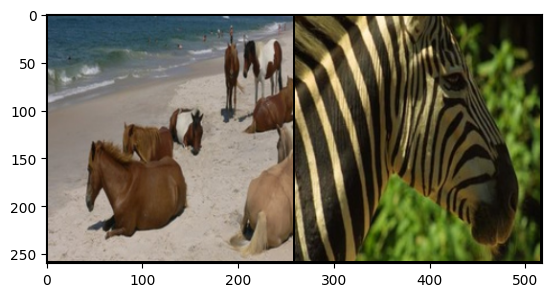

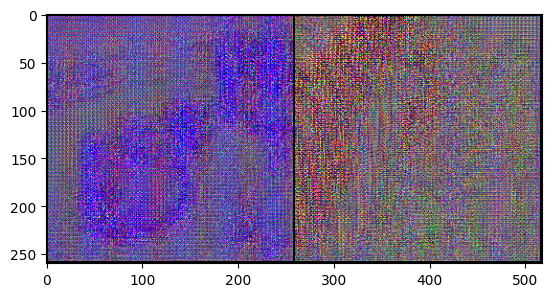

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 2: Step 200: Generator (U-Net) loss: 6.990950682163236, Discriminator loss: 0.272780328541994


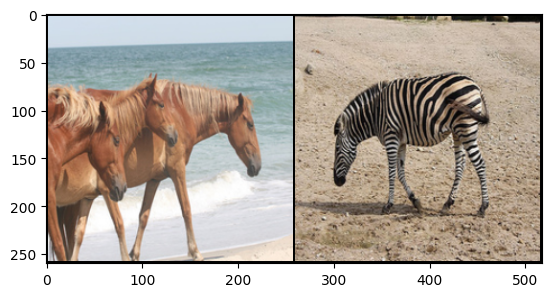

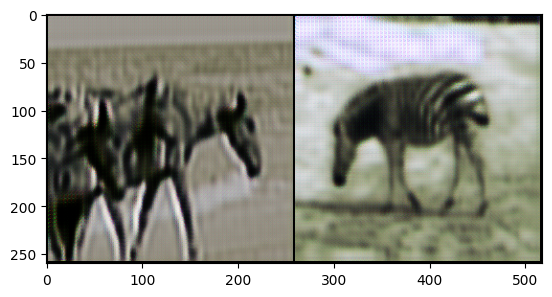

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 4: Step 400: Generator (U-Net) loss: 6.144492532014849, Discriminator loss: 0.21732861246913657


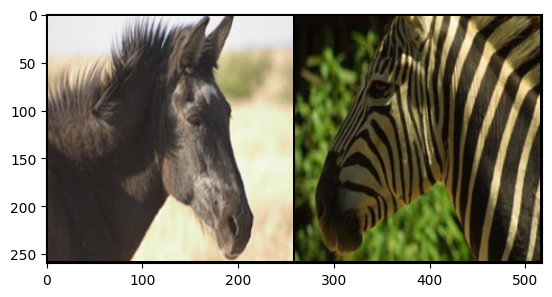

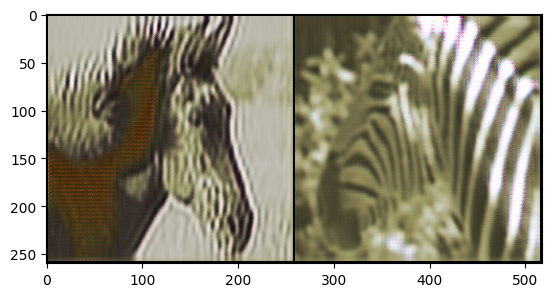

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 6: Step 600: Generator (U-Net) loss: 5.761960906982421, Discriminator loss: 0.21412100818008192


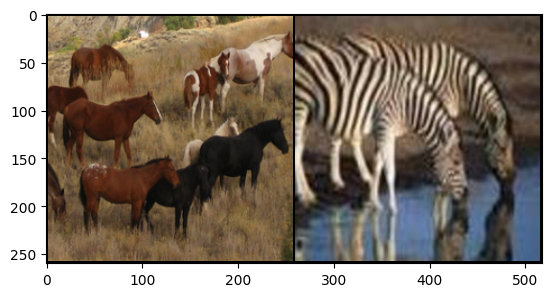

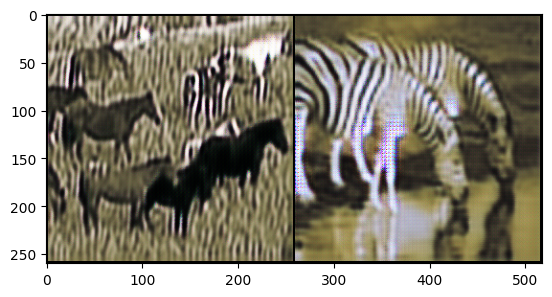

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 8: Step 800: Generator (U-Net) loss: 5.566163277626036, Discriminator loss: 0.22138562534004458


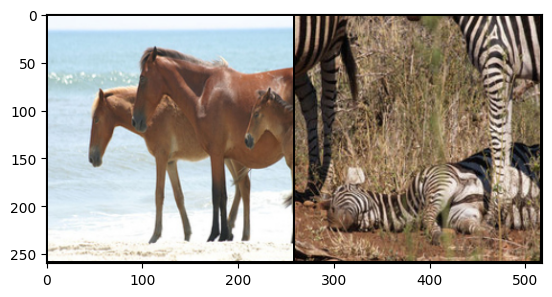

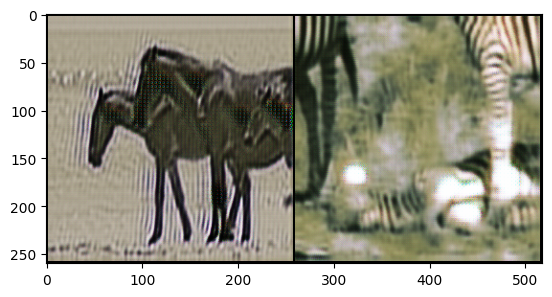

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 10: Step 1000: Generator (U-Net) loss: 5.6012214601039885, Discriminator loss: 0.21545078881084925


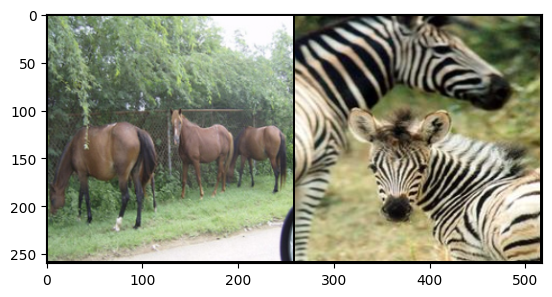

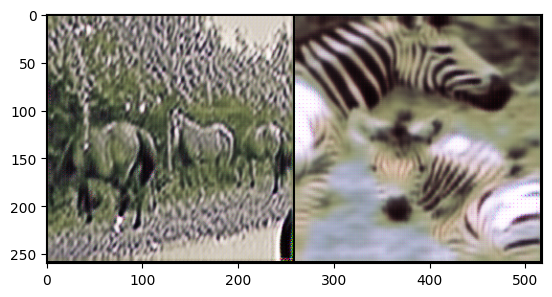

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 12: Step 1200: Generator (U-Net) loss: 5.4506350457668304, Discriminator loss: 0.2244955603405835


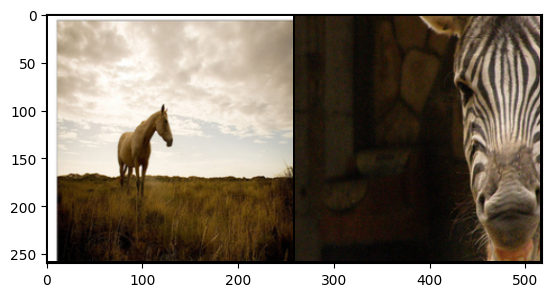

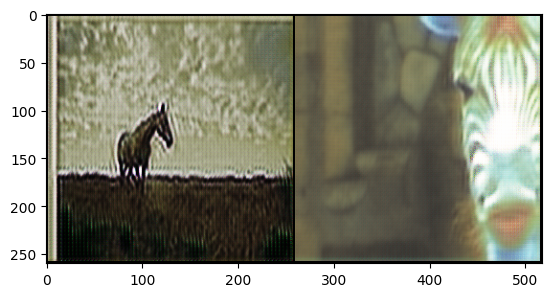

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 14: Step 1400: Generator (U-Net) loss: 5.211579842567447, Discriminator loss: 0.22180028602480883


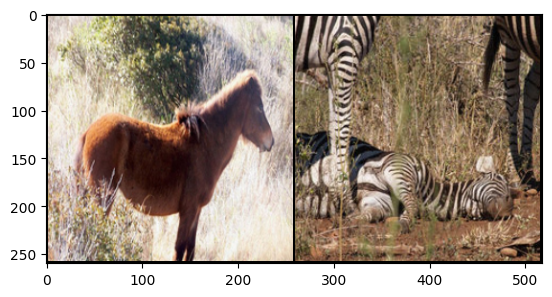

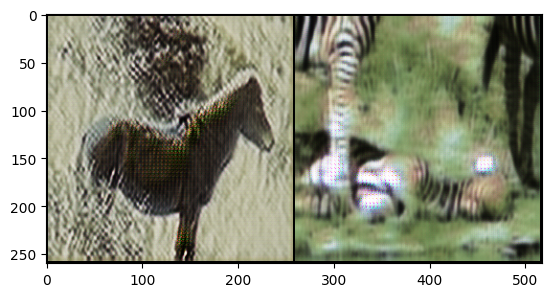

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 16: Step 1600: Generator (U-Net) loss: 5.221450967788697, Discriminator loss: 0.22644660234451297


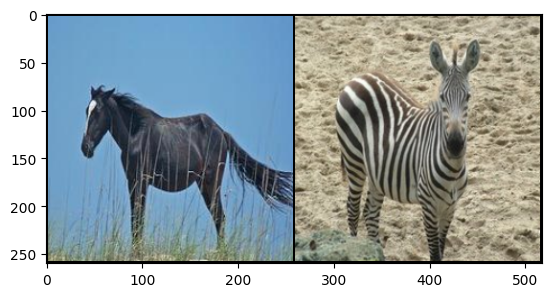

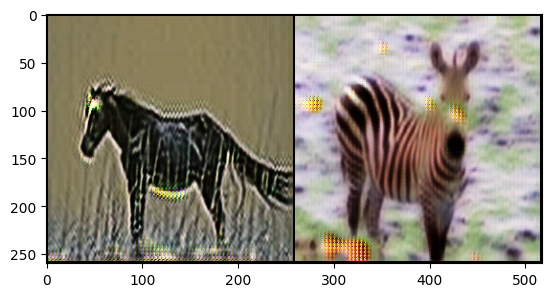

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 18: Step 1800: Generator (U-Net) loss: 5.2976094508171085, Discriminator loss: 0.22710070345550779


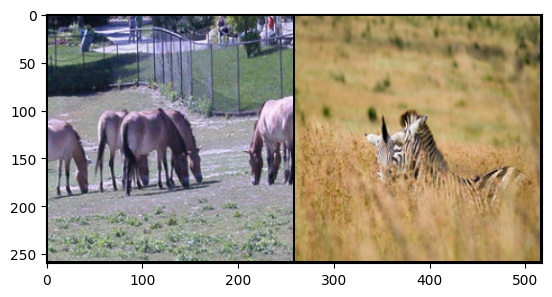

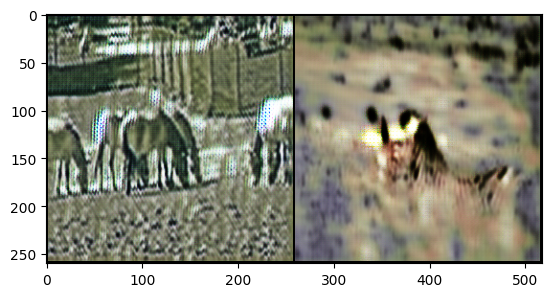

100%|██████████| 100/100 [01:06<00:00,  1.50it/s]


In [28]:
def train(save_model=False):
    mean_generator_loss = 0
    mean_discriminator_loss = 0
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    cur_step = 0

    for epoch in range(n_epochs):
        # The dataloader returns the batches
        # for image, _ in tqdm(dataloader):
        for real_A, real_B in tqdm(dataloader):
            real_A = nn.functional.interpolate(real_A, size=target_shape)
            real_B = nn.functional.interpolate(real_B, size=target_shape)
            cur_batch_size = len(real_A)
            real_A = real_A.to(device)
            real_B = real_B.to(device)

            ### Update discriminator A ###
            disc_A_opt.zero_grad()  # Zero out the gradient before backpropagation
            with torch.no_grad():
                fake_A = gen_BA(real_B)
            disc_A_loss = get_disc_loss(real_A, fake_A, disc_A, adv_criterion)
            disc_A_loss.backward(retain_graph=True)  # Update gradients
            disc_A_opt.step()  # Update optimizer

            ### Update discriminator B ###
            disc_B_opt.zero_grad()  # Zero out the gradient before backpropagation
            with torch.no_grad():
                fake_B = gen_AB(real_A)
            disc_B_loss = get_disc_loss(real_B, fake_B, disc_B, adv_criterion)
            disc_B_loss.backward(retain_graph=True)  # Update gradients
            disc_B_opt.step()  # Update optimizer

            ### Update generator ###
            gen_opt.zero_grad()
            gen_loss, fake_A, fake_B = get_gen_loss(
                real_A, real_B, gen_AB, gen_BA, disc_A, disc_B, adv_criterion, recon_criterion, recon_criterion
            )
            gen_loss.backward()  # Update gradients
            gen_opt.step()  # Update optimizer

            # Keep track of the average discriminator loss
            mean_discriminator_loss += disc_A_loss.item() / display_step
            # Keep track of the average generator loss
            mean_generator_loss += gen_loss.item() / display_step

            ### Visualization code ###
            if cur_step % display_step == 0:
                print(f"Epoch {epoch}: Step {cur_step}: Generator (U-Net) loss: {mean_generator_loss}, Discriminator loss: {mean_discriminator_loss}")
                show_tensor_images(torch.cat([real_A, real_B]), size=(dim_A, target_shape, target_shape))
                show_tensor_images(torch.cat([fake_B, fake_A]), size=(dim_B, target_shape, target_shape))
                mean_generator_loss = 0
                mean_discriminator_loss = 0
            cur_step += 1

        if save_model:
            torch.save(gen_AB.state_dict(), 'pth/gen_AB.pth')
            torch.save(gen_BA.state_dict(), 'pth/gen_BA.pth')
            torch.save(disc_A.state_dict(), 'pth/disc_A.pth')
            torch.save(disc_B.state_dict(), 'pth/disc_B.pth')


train(save_model=True)

### Upload the model to Huggingface!

In [29]:
# Periksa apakah file .pth disimpan di direktori /pth
!ls pth


disc_A.pth  disc_B.pth	gen_AB.pth  gen_BA.pth


In [45]:
!huggingface-cli login

from huggingface_hub import HfApi, create_repo
api = HfApi()

# Create a Huggingface model repo and use the name here
repo_name = "khaliiishah/huggingface_khalishah"

create_repo(repo_name)

api.upload_folder(
    folder_path="pth",
    repo_id=repo_name,
    repo_type="model",
)



    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) Y
Token is valid (permission: fineG

disc_B.pth:   0%|          | 0.00/11.1M [00:00<?, ?B/s]

disc_A.pth:   0%|          | 0.00/11.1M [00:00<?, ?B/s]

gen_AB.pth:   0%|          | 0.00/45.5M [00:00<?, ?B/s]

gen_BA.pth:   0%|          | 0.00/45.5M [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/khaliiishah/huggingface_khalishah/commit/495d93c2d67f7b58100389db1e931b6b3b40f058', commit_message='Upload folder using huggingface_hub', commit_description='', oid='495d93c2d67f7b58100389db1e931b6b3b40f058', pr_url=None, repo_url=RepoUrl('https://huggingface.co/khaliiishah/huggingface_khalishah', endpoint='https://huggingface.co', repo_type='model', repo_id='khaliiishah/huggingface_khalishah'), pr_revision=None, pr_num=None)